In [130]:
from os import  path, makedirs, remove
from zipfile import ZipFile
from shutil import rmtree
import pandas as pd
import numpy as np
import re
import math
from collections import defaultdict

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error

%pip install matplotlib
import matplotlib.pyplot as plt

%pip install xmltodict
import xmltodict


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [131]:
if not path.exists('data'):
    makedirs('data')
if not path.exists('data/animelist.csv') and not path.exists('data/anime_with_synopsis.csv'):
    print("Dezipping... (may take a while)")
    with ZipFile("archive.zip", 'r') as zip_ref:
        zip_ref.extractall('data')
        rmtree("data/html folder") 
        remove("data/watching_status.csv")
        remove("data/rating_complete.csv")
        remove("data/anime.csv")

Dezipping... (may take a while)


In [132]:
df_anime = pd.read_csv("data/anime_with_synopsis.csv", sep=',', encoding='utf-8')
df_anime

,MAL_ID,Name,Score,Genres,sypnopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...
...,...,...,...,...,...
16209,48481,Daomu Biji Zhi Qinling Shen Shu,Unknown,"Adventure, Mystery, Supernatural",No synopsis information has been added to this...
16210,48483,Mieruko-chan,Unknown,"Comedy, Horror, Supernatural",ko is a typical high school student whose life...
16211,48488,Higurashi no Naku Koro ni Sotsu,Unknown,"Mystery, Dementia, Horror, Psychological, Supe...",Sequel to Higurashi no Naku Koro ni Gou .
16212,48491,Yama no Susume: Next Summit,Unknown,"Adventure, Slice of Life, Comedy",New Yama no Susume anime.


In [133]:
df_anime = df_anime.rename(columns={"sypnopsis": "synopsis"})
df_anime["synopsis"].fillna("", inplace=True)
df_anime = df_anime.rename(columns={"MAL_ID": "anime_id"})
df_anime["synopsis"] = df_anime["synopsis"].replace("No synopsis information has been added to this title. Help improve our database by adding a synopsis here .", "")
df_anime["synopsis"] = df_anime["synopsis"].replace("No synopsis has been added for this series yet. Click here to update this information.", "")
df_anime['synopsis'] = df_anime['Name'] + ' ' + df_anime['Genres'] + ' ' + df_anime['synopsis'] 

df_anime

,anime_id,Name,Score,Genres,synopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","Cowboy Bebop Action, Adventure, Comedy, Drama,..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space","Cowboy Bebop: Tengoku no Tobira Action, Drama,..."
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Trigun Action, Sci-Fi, Adventure, Comedy, Dram..."
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...","Witch Hunter Robin Action, Mystery, Police, Su..."
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural","Bouken Ou Beet Adventure, Fantasy, Shounen, Su..."
...,...,...,...,...,...
16209,48481,Daomu Biji Zhi Qinling Shen Shu,Unknown,"Adventure, Mystery, Supernatural","Daomu Biji Zhi Qinling Shen Shu Adventure, Mys..."
16210,48483,Mieruko-chan,Unknown,"Comedy, Horror, Supernatural","Mieruko-chan Comedy, Horror, Supernatural ko i..."
16211,48488,Higurashi no Naku Koro ni Sotsu,Unknown,"Mystery, Dementia, Horror, Psychological, Supe...","Higurashi no Naku Koro ni Sotsu Mystery, Demen..."
16212,48491,Yama no Susume: Next Summit,Unknown,"Adventure, Slice of Life, Comedy","Yama no Susume: Next Summit Adventure, Slice o..."


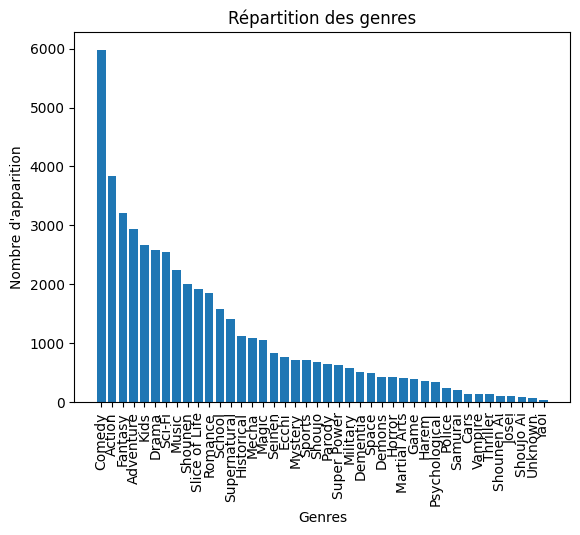

In [135]:
d_genres = defaultdict(int)
for genres in df_anime['Genres'] :
    for i in genres.split(',') :
        d_genres[i.strip()] += 1
d_genres = dict(sorted(d_genres.items(), key=lambda x: x[1], reverse=True))
plt.bar(d_genres.keys(), d_genres.values())
plt.title('Répartition des genres')
plt.xlabel('Genres')
plt.ylabel('Nombre d\'apparition')
plt.xticks(rotation=90)
plt.show()

In [136]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_anime['synopsis'])

tfidf_matrix.shape

(16214, 50214)

In [137]:
def clean(line):
    line = line.lower()
    line = " ".join(line.split(","))
    line = " ".join(line.split("."))
    line = " ".join(line.split(";"))
    line = " ".join(line.split("/"))
    pattern = re.compile(r'(\bfirst|second|third|fourth|fifth|sixth|seventh|eighth|ninth|tenth)\s+season\b', re.IGNORECASE)
    line = pattern.sub(lambda match: f'season{match.group(1)}', line) 
    pattern = 'No synopsis information has been added to this title. Help improve our database by adding a synopsis'
    line = re.sub(pattern, "", line)
    pattern = 'No synopsis has been added for this series yet. Click here to update this information'
    line = re.sub(pattern, "", line)
    return line
df_anime.loc[:, 'synopsis'] = [clean(x) for x in df_anime['synopsis']]
df_anime['Score'] = pd.to_numeric(df_anime['Score'], errors='coerce')
df_anime_forest = df_anime.dropna(subset=['Score'])
df_anime_forest.loc[:, 'Score'] = df_anime_forest['Score'].round().astype({'Score': 'int32'}) 

C:\Users\migue\AppData\Local\Temp\ipykernel_2404\838325813.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_anime_forest.loc[:, 'Score'] = df_anime_forest['Score'].round().astype({'Score': 'int32'})
C:\Users\migue\AppData\Local\Temp\ipykernel_2404\838325813.py:17: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_anime_forest.loc[:, 'Score'] = df_anime_forest['Score'].round().astype({'Score': 'int32'})


In [138]:
X_train, X_test, y_train, y_test = train_test_split(df_anime_forest['synopsis'], df_anime_forest['Score'], test_size=0.2, random_state=42)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [139]:
forest = RandomForestClassifier(n_estimators=100, random_state=123456789)
forest.fit(X_train_tfidf, y_train)

y_pred = forest.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.52


In [140]:
feature_importances = forest.feature_importances_
feature_names = np.array(tfidf.get_feature_names_out())
selected_features = feature_names[feature_importances > 0.000001] 

In [141]:
sorted_features = sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True)

print('Mots les plus déterminants: ', len(selected_features), '/', len(feature_names) )
for i, (feature, importance) in enumerate(sorted_features):
    print(f'{feature}: {importance:.4f}')

Mots les plus déterminants:  25878 / 38940
comedy: 0.0072
source: 0.0056
shounen: 0.0054
dementia: 0.0052
drama: 0.0052
romance: 0.0050
action: 0.0049
school: 0.0041
music: 0.0041
short: 0.0041
life: 0.0040
fantasy: 0.0039
adventure: 0.0039
video: 0.0038
animation: 0.0033
sci: 0.0033
fi: 0.0032
song: 0.0031
kids: 0.0031
supernatural: 0.0028
series: 0.0028
ann: 0.0028
film: 0.0027
slice: 0.0027
movie: 0.0025
seinen: 0.0024
world: 0.0023
anime: 0.0023
new: 0.0023
special: 0.0022
magic: 0.0021
story: 0.0021
mystery: 0.0021
episode: 0.0020
mecha: 0.0020
dvd: 0.0019
ecchi: 0.0019
shoujo: 0.0019
included: 0.0018
military: 0.0018
girl: 0.0018
sports: 0.0017
high: 0.0017
time: 0.0017
power: 0.0017
anidb: 0.0017
historical: 0.0017
game: 0.0017
episodes: 0.0017
friends: 0.0017
season: 0.0016
specials: 0.0016
day: 0.0016
ova: 0.0016
parody: 0.0016
official: 0.0016
young: 0.0016
japanese: 0.0015
bundled: 0.0015
animated: 0.0015
tv: 0.0015
manga: 0.0015
mysterious: 0.0015
super: 0.0014
ray: 0.0014


In [142]:
tfidf.fit(selected_features)
tfidf_matrix = tfidf.transform(df_anime['synopsis'])

In [143]:
# from sklearn.neighbors import NearestNeighbors

# knn_model = NearestNeighbors(n_neighbors=500, metric='cosine')
# knn_model.fit(tfidf_matrix)
# similar_animes = knn_model.kneighbors(tfidf_matrix)
# knn_model.kneighbors_graph(tfidf_matrix).toarray()

In [144]:
cosine_sim =  cosine_similarity(tfidf_matrix) #knn_model.kneighbors_graph(tfidf_matrix).toarray()
cosine_sim

array([[1.        , 0.31467126, 0.10325566, ..., 0.        , 0.09548198,
        0.11694107],
       [0.31467126, 1.        , 0.11519746, ..., 0.0210538 , 0.02663118,
        0.06523281],
       [0.10325566, 0.11519746, 1.        , ..., 0.        , 0.1048645 ,
        0.01605403],
       ...,
       [0.        , 0.0210538 , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.09548198, 0.02663118, 0.1048645 , ..., 0.        , 1.        ,
        0.04082483],
       [0.11694107, 0.06523281, 0.01605403, ..., 0.        , 0.04082483,
        1.        ]])

In [145]:
df_user = pd.read_csv("data/animelist.csv", sep=',', encoding='utf-8')
df_user.head()

,user_id,anime_id,rating,watching_status,watched_episodes
0,0,67,9,1,1
1,0,6702,7,1,4
2,0,242,10,1,4
3,0,4898,0,1,1
4,0,21,10,1,0


In [16]:
df_user['rating'].value_counts(normalize=True)*100

0     42.872184
8     14.119648
7     13.041580
9      9.371442
6      6.906289
10     6.541001
5      3.689315
4      1.689960
3      0.829208
2      0.499282
1      0.440091
Name: rating, dtype: float64

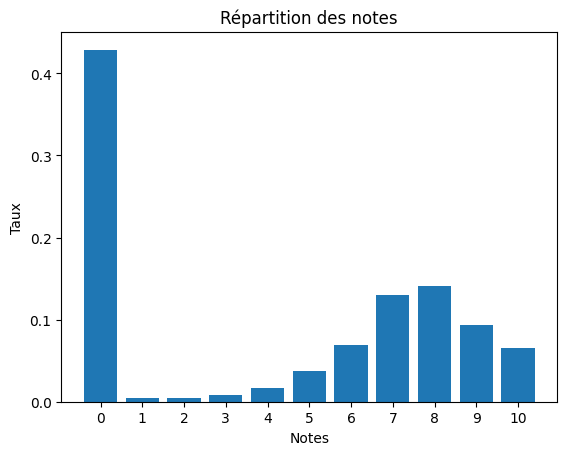

In [146]:
count_ratings = (df_user['rating'].value_counts(normalize=True))

plt.bar(count_ratings.index, count_ratings.values)
plt.title('Répartition des notes')
plt.xlabel('Notes')
plt.ylabel('Taux')
plt.xticks(range(0, 11))
plt.show()

In [147]:
df_user = df_user.astype({'rating': 'int32'})
df_user = df_user[df_user['rating'] != 0]
df_user = df_user.drop(['watching_status'], axis=1)
df_user = df_user.drop(['watched_episodes'], axis=1)
c= df_user['user_id'].value_counts()
df_user = df_user[df_user['user_id'].isin(c[c >= 25].index)].copy()
df_user

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
4,0,21,10
5,0,24,9
...,...,...,...
109224741,353404,243,7
109224742,353404,507,7
109224743,353404,392,9
109224744,353404,882,6


In [148]:
def split_set(user_ratings, add_bad = []):

    train = []
    test = []
    sum_train = 0
    sum_test = 0

    for i, (x, score) in user_ratings.items():
        if i % 2 == 0 or sum_train <= sum_test or x in add_bad:
            train.append((i, x, score))
            sum_train += score
        else:
            test.append((i, x, score))
            sum_test += score

    return train, test

In [149]:
def content_recommend(similarity_matrix, user_ratings, add_bad = [], k = None):
    if k is None:
        set_train , set_test = split_set(user_ratings, add_bad)
        print(f'Train set: {len(set_train)}')
        print(f'Test set: {len(set_test)}')
    else:
        set_train = [(i, x, score) for i, (x, score) in user_ratings.items()]
        set_test = []
    


    ratings = []
    for i in range(len(similarity_matrix)):
        h = 0
        b = 0
        for pos, _, score in set_train:
            h += score * similarity_matrix[i][pos]
            b += similarity_matrix[i][pos]
        if b == 0:
            ratings.append((i, 0))
        else:
            rating = h / b
            if not np.isnan(rating) and not np.isinf(rating):
                ratings.append((i, rating))
            else:
                ratings.append((i, 0))

    ratings.sort(key=lambda x: x[1], reverse=True)
    if k is None:
        return ratings,  set_test
    return ratings[:k], set_test


In [150]:
def balacing_ratings(user_ratings):
    animes_added = []
    select_animes = {y[1]: (y[0], x) for (x, y) in {user_ratings[x][1]: (user_ratings[x][0], x) for x in user_ratings}.items()}
    bad_animes = sorted(select_animes.items(), key=lambda x: x[1][1])[:5]
    nb_ratings = len(user_ratings)
    for anime in bad_animes :
        sim_ind = cosine_similarity(tfidf_matrix[anime[0]], tfidf_matrix)[0].argsort()[::-1][1:int(nb_ratings*0.01)+1]
        # print("----------------------------------")
        # for m in sim_ind:
        #     print(df_anime.iloc[m]['Name'])
        for ind in sim_ind : 
            if df_anime.iloc[ind]['anime_id'] not in animes_added :
                user_ratings[ind] = (df_anime.iloc[ind]['anime_id'],anime[1][1])
                animes_added.append(df_anime.iloc[ind]['anime_id'])
    return animes_added

In [151]:
from collections import defaultdict
user = df_user[df_user['user_id'] == 437]
user_ratings = defaultdict(tuple)
animes_added = []
for i, row in user.iterrows():
    ind = df_anime[df_anime['anime_id'] == row['anime_id']].index[0]
    user_ratings[ind] = (row['anime_id'], row['rating'])
    
# animes_added = balacing_ratings(user_ratings)
        
print(f'len user_ratings: {len(user_ratings)}')

len user_ratings: 549


In [152]:
l, test_set = content_recommend(cosine_sim, user_ratings, animes_added)
ratings_pred = []
ratings_true = []

for x, n in l:
    for i, _, score in test_set:
        if x == i:
            print(f'{df_anime.iloc[x]["Name"]}: {n} (expected: {score})')
            if score > 1:
                ratings_pred.append(n) 
                ratings_true.append(score)
            break

Train set: 280
Test set: 269
D4DJ: First Mix: 9.206923103017553 (expected: 8)
Kandagawa Jet Girls OVA: 8.97205724215926 (expected: 7)
Yes! BanG_Dream!: 8.86860221760295 (expected: 10)
K-On!: 8.776924307435118 (expected: 10)
Black★Rock Shooter (OVA): 8.768604546993798 (expected: 10)
The iDOLM@STER Cinderella Girls: 8.754867597319326 (expected: 10)
Rikaisha: 8.751272013761874 (expected: 8)
Love Live! Nijigasaki Gakuen School Idol Doukoukai: 8.745142855137289 (expected: 10)
Yuru Yuri: 8.744953812987085 (expected: 10)
Garugaku.: Sei Girls Square Gakuin: 8.742051686225828 (expected: 8)
Kandagawa Jet Girls: 8.731767128723709 (expected: 10)
K-On!!: 8.731473550476863 (expected: 10)
Robot Girls Z Plus: 8.726524180022896 (expected: 10)
Ochikobore Fruit Tart: 8.719827000487786 (expected: 9)
Myself; Yourself: 8.716913472406276 (expected: 9)
Lovedol: Lovely Idol: 8.708244673821202 (expected: 10)
Love Live! Sunshine!! The School Idol Movie: Over the Rainbow: 8.70155620884221 (expected: 10)
Boku wa T

In [153]:
mae = mean_absolute_error(ratings_true, ratings_pred)
print("MAE:", mae)

min_rating = 1  
max_rating =  10  
nmae = mae / (max_rating - min_rating)
print("NMAE:", nmae)
class_weights = df_user['rating'].value_counts(normalize=True)
weights = pd.Series(ratings_true).map(class_weights)
wmae = mean_absolute_error(ratings_true, ratings_pred, sample_weight=weights)
print("WMAE:", wmae)


MAE: 1.3979582933318697
NMAE: 0.15532869925909665
WMAE: 1.210310990286346


In [154]:
def error_recommend(user_ratings, animes_added = []):
    l, test_set = content_recommend(cosine_sim, user_ratings, animes_added)
    ratings_pred = []
    ratings_true = []
    for x, n in l:
        for i, _, score in test_set:
            if x == i:
                ratings_pred.append(n) 
                ratings_true.append(score)
                break

    mae = mean_absolute_error(ratings_true, ratings_pred)
    min_rating = 1  
    max_rating =  10  
    nmae = mae / (max_rating - min_rating)
    class_weights = df_user['rating'].value_counts(normalize=True)
    weights = pd.Series(ratings_true).map(class_weights)
    wmae = mean_absolute_error(ratings_true, ratings_pred, sample_weight=weights)
    return mae, wmae

In [155]:
def sampled_range(mini, maxi, num):
    if not num:
        return []
    lmini = math.log(mini)
    lmaxi = math.log(maxi)
    ldelta = (lmaxi - lmini) / (num - 1)
    out = [x for x in set([int(math.exp(lmini + i * ldelta)) for i in range(num)])]
    out.sort()
    return out

In [97]:
n = 0
v = 0
acc_mae, acc_wmae = 0, 0 
for id in sampled_range(df_user['user_id'].min()+1, df_user['user_id'].max(), 200):
    v += 1
    user = df_user[df_user['user_id'] == id]
    if len(user) != 0 :
        user_ratings = defaultdict(tuple)
        animes_added = []
        for i, row in user.iterrows():
            try :
                ind = df_anime[df_anime['anime_id'] == row['anime_id']].index[0]
                user_ratings[ind] = (row['anime_id'], row['rating'])
            except:
                pass
        # animes_added = balacing_ratings(user_ratings)
        if len(user_ratings) > 25 :
           error = error_recommend(user_ratings, animes_added)
           acc_mae += error[0]
           acc_wmae += error[1]
           n += 1
           print(n, "/", v)

Train set: 65
Test set: 52
1 / 1
Train set: 28
Test set: 20
2 / 2
Train set: 164
Test set: 156
3 / 3
Train set: 67
Test set: 57
4 / 4
Train set: 26
Test set: 20
5 / 5
Train set: 168
Test set: 160
6 / 6
Train set: 53
Test set: 38
7 / 7
Train set: 89
Test set: 84
8 / 11
Train set: 33
Test set: 28
9 / 12
Train set: 15
Test set: 12
10 / 13
Train set: 57
Test set: 44
11 / 14
Train set: 138
Test set: 115
12 / 16
Train set: 353
Test set: 351
13 / 17
Train set: 409
Test set: 398
14 / 18
Train set: 47
Test set: 37
15 / 19
Train set: 250
Test set: 237
16 / 20
Train set: 31
Test set: 25
17 / 21
Train set: 45
Test set: 42
18 / 24
Train set: 38
Test set: 25
19 / 25
Train set: 41
Test set: 40
20 / 26
Train set: 104
Test set: 94
21 / 27
Train set: 77
Test set: 77
22 / 28
Train set: 48
Test set: 36
23 / 29
Train set: 133
Test set: 103
24 / 30
Train set: 200
Test set: 195
25 / 31
Train set: 166
Test set: 144
26 / 32
Train set: 52
Test set: 44
27 / 33
Train set: 276
Test set: 259
28 / 34
Train set: 44
T

In [156]:
# Mean Absolute Error
print("MAE :", acc_mae/n)
# Weighted Mean Absolute Error
print("WMAE :", acc_wmae/n)

MAE : 22.324525114746063
WMAE : 17.972568655459213


In [157]:
with open('animelist_1702575696_-_7648693.xml', 'r') as file:
    data = file.read()

data_dict = xmltodict.parse(data)
data_dict

{'myanimelist': {'myinfo': {'user_id': '7648693',
   'user_name': 'Pom4Pote',
   'user_export_type': '1',
   'user_total_anime': '480',
   'user_total_watching': '14',
   'user_total_completed': '340',
   'user_total_onhold': '7',
   'user_total_dropped': '11',
   'user_total_plantowatch': '108'},
  'anime': [{'series_animedb_id': '6408',
    'series_title': '"Bungaku Shoujo" Movie',
    'series_type': 'Movie',
    'series_episodes': '1',
    'my_id': '0',
    'my_watched_episodes': '1',
    'my_start_date': '0000-00-00',
    'my_finish_date': '0000-00-00',
    'my_rated': None,
    'my_score': '7',
    'my_storage': None,
    'my_storage_value': '0.00',
    'my_status': 'Completed',
    'my_comments': None,
    'my_times_watched': '0',
    'my_rewatch_value': None,
    'my_priority': 'LOW',
    'my_tags': None,
    'my_rewatching': '0',
    'my_rewatching_ep': '0',
    'my_discuss': '1',
    'my_sns': 'default',
    'update_on_import': '0'},
   {'series_animedb_id': '52034',
    'seri

In [158]:
my_list = {}

for data in data_dict['myanimelist']['anime']:
    series_animedb_id = int(data['series_animedb_id'])
    my_score = int(data['my_score'])
    
    # Assuming 'anime_id' is the column name in df_anime
    ind = df_anime[df_anime['anime_id'] == series_animedb_id].index
    
    if not ind.empty and my_score != 0:
        ind = ind[0]
        my_list[ind] = (series_animedb_id, my_score)

my_list

{3932: (6408, 7),
 4034: (6682, 5),
 12669: (36793, 9),
 13371: (37956, 9),
 13493: (38101, 9),
 15345: (41457, 10),
 12194: (36039, 7),
 8318: (25397, 8),
 11518: (34881, 6),
 1507: (1734, 7),
 7653: (22199, 9),
 7637: (22147, 7),
 3981: (6547, 9),
 5243: (9989, 8),
 5673: (11111, 9),
 8208: (24833, 9),
 9548: (30654, 9),
 12725: (36882, 9),
 13752: (38572, 6),
 12479: (36516, 7),
 13429: (38020, 6),
 13227: (37716, 8),
 7478: (21405, 8),
 13543: (38186, 8),
 14637: (40004, 8),
 10790: (33475, 7),
 1470: (1689, 8),
 16044: (44511, 9),
 8887: (28999, 7),
 15155: (40960, 7),
 14387: (39523, 6),
 11251: (34382, 6),
 13990: (38940, 7),
 15602: (42310, 9),
 6839: (17827, 6),
 5934: (12549, 3),
 9314: (30127, 7),
 9981: (31683, 8),
 12114: (35849, 10),
 13792: (38656, 6),
 14858: (40416, 10),
 15641: (42423, 10),
 6399: (15583, 8),
 7088: (19163, 8),
 7823: (22961, 6),
 12564: (36633, 9),
 15349: (41461, 9),
 8170: (24655, 7),
 6793: (17641, 8),
 11310: (34497, 9),
 1336: (1535, 9),
 13392:

In [159]:
l, test_set = content_recommend(cosine_sim, my_list, k=32000)
for x, n in l:
    if x not in my_list and df_anime.iloc[x]['Genres'].find('Music') == -1:
        print(f'{df_anime.iloc[x]["Name"]}: {n}')

Yami no Kioku, Yume no Inei: 10.0
Shimajirou to Sora Tobu Fune: 9.649501875624276
Yume 10 Yoru: 9.06112898456185
Lotus: 9.0
Shu Ling Ji: 8.965413220616629
Ninja Tamamaru: Toukaidou Gojuusan-ji: 8.91961196345405
Seisho Gensou Fu: Adam to Eve: 8.86606959853089
Hyoutan: 8.848277070790864
It's Marey O'Clock Now!: 8.830605375889965
Acchi Kocchi: 8.82338382299267
Kkoma Bus Tayo 3: 8.747834535134533
Lei Su Deng Shandian Chong Xian 3: 8.747834535134533
Cocomong 3: 8.747834535134531
Rule: 8.578112026056306
Ten: 8.519075342376135
Hello Kitty no Shiawase no Aoi Hotaru: 8.48979485078768
Stone: 8.485821095665841
Yakusoku: 8.480352492312903
Porong Porong Pororo 5: 8.466624124280417
Tottoko Hamtarou: "A" kara "N" made Hiragana Asobi: 8.452624033915832
Fuyu no Hi: 8.43626021242391
Kensaku to Enjin no Happy Birthday: 8.406380424320066
Entotsuya Peroo: 8.368513445784584
Sougiya to Inu: 8.362733858926976
Ninja Tamamaru no Hi no Youjin: 8.359329827145784
Osaru no Monkichi no Kin no Ono Gin no Ono: 8.35277

In [104]:
import random
test_list = {}
l = df_anime[df_anime['Genres'].str.contains('Horror')].sample(250)
l_id = []

for i, row in l.iterrows():
    l_id.append(i)
    test_list[i] = (row['anime_id'], 9  + random.randint(-1, 1))

kids = df_anime[df_anime['Genres'].str.contains('Kids')].sample(50)

for i, row in kids.iterrows():
    l_id.append(i)
    test_list[i] = (row['anime_id'], 2)

test_list

{690: (777, 8),
 1268: (1454, 10),
 292: (326, 9),
 15469: (41851, 9),
 10171: (32189, 9),
 1304: (1494, 10),
 3732: (5918, 8),
 36: (55, 9),
 2798: (3525, 8),
 1178: (1342, 8),
 13798: (38668, 10),
 12176: (36003, 9),
 238: (270, 9),
 4545: (8150, 10),
 15862: (42976, 10),
 10962: (33820, 9),
 5673: (11111, 10),
 6225: (14117, 9),
 7674: (22319, 9),
 1033: (1163, 8),
 13041: (37437, 8),
 2023: (2346, 10),
 9682: (30967, 10),
 7855: (23063, 9),
 15595: (42290, 8),
 4568: (8194, 8),
 13051: (37451, 9),
 470: (514, 8),
 7123: (19315, 9),
 13960: (38906, 10),
 12260: (36135, 8),
 1091: (1225, 8),
 15171: (41006, 9),
 5251: (10003, 8),
 7389: (20855, 9),
 4552: (8158, 8),
 6596: (16694, 10),
 2599: (3166, 9),
 376: (413, 9),
 8101: (24127, 10),
 3624: (5624, 8),
 1754: (2017, 8),
 14550: (39836, 10),
 1309: (1500, 9),
 5062: (9544, 9),
 2487: (2978, 8),
 9549: (30659, 9),
 12782: (36992, 10),
 11593: (35009, 8),
 11700: (35140, 9),
 507: (553, 8),
 10624: (33144, 9),
 15302: (41340, 9),
 5

In [160]:
l, test_set = content_recommend(cosine_sim, test_list, k=20)
for x, n in l:
    if x not in l_id:
        print(f'{df_anime.iloc[x]["Genres"]}, {df_anime.iloc[x]["Name"]}: {n}')

Dementia, Yami no Kioku, Yume no Inei: 9.119876785610172
Dementia, Aru Apartment no Isshitsu: 9.081204331874103
Romance, Shiohi Girls: Vongole Bianco: 9.058649239884126
Dementia, Natsu no Shisen 1942: 9.013735407917627
Dementia, The Harmonic Gleam Vibration: 9.013735407917627
Dementia, Chirico: 9.013735407917624
Dementia, Shunga: 9.013735407917624
Dementia, Fusuma 2: 9.013735407917624
Dementia, Wild Cleaner: 9.013735407917624
Dementia, Goldfish Fetish: 9.013391546267496
Dementia, Propagate: 9.013226597962749
Dementia, Yume 10 Yoru: 9.012255527870238
Dementia, Ecchi, MTV Ident: Horny: 8.995636420599974
Romance, Yeon-ae Halujeon: 8.995500652022189
Dementia, Templex: 8.993316705052182
Dementia, Tanaami Keiichi no Shouzou: 8.989814971929773
Dementia, Fetish Doll: 8.982065793318892
Dementia, Psychological, Ushinawareta Choushoku: 8.944299293057004
Ecchi, Iya na Kao sare nagara Opantsu Misete Moraitai 2: 8.924552336845789
School, Promedicus: 8.905581777159298


In [161]:
test_list = {}
l = df_anime[df_anime['Genres'].str.contains('Romance')].sample(350)
l_id = []

for i, row in l.iterrows():
    l_id.append(i)
    test_list[i] = (row['anime_id'], 9  + random.randint(-1, 1))

horror = df_anime[df_anime['Genres'].str.contains('Horror')].sample(50)

for i, row in horror.iterrows():
    l_id.append(i)
    test_list[i] = (row['anime_id'], 2)

sliceoflife = df_anime[df_anime['Genres'].str.contains('Slice of Life')].sample(100)

for i, row in sliceoflife.iterrows():
    l_id.append(i)
    test_list[i] = (row['anime_id'], 8  + random.randint(-1, 1))

test_list

{1012: (1142, 9),
 10106: (31980, 10),
 8182: (24703, 10),
 2877: (3701, 8),
 4737: (8643, 10),
 606: (661, 10),
 840: (957, 9),
 2085: (2460, 9),
 15746: (42714, 10),
 13668: (38435, 8),
 979: (1104, 10),
 1671: (1922, 8),
 10095: (31952, 8),
 14512: (39753, 8),
 211: (243, 8),
 16158: (47402, 9),
 8731: (28299, 10),
 11549: (34934, 9),
 10690: (33247, 10),
 122: (144, 10),
 14407: (39559, 10),
 8730: (28297, 8),
 1273: (1459, 10),
 362: (397, 9),
 1806: (2071, 10),
 227: (259, 9),
 6174: (13767, 8),
 10869: (33654, 8),
 4842: (8900, 10),
 831: (942, 9),
 4304: (7377, 8),
 15113: (40876, 8),
 8423: (26043, 10),
 6041: (13093, 10),
 12694: (36824, 9),
 2998: (3914, 8),
 1424: (1637, 10),
 16193: (48413, 9),
 12519: (36578, 9),
 10573: (33048, 8),
 15773: (42786, 10),
 5958: (12673, 8),
 10104: (31977, 10),
 13906: (38826, 9),
 3915: (6366, 8),
 1365: (1567, 8),
 9884: (31483, 8),
 7687: (22411, 9),
 733: (836, 9),
 9632: (30895, 8),
 3663: (5734, 8),
 1839: (2104, 8),
 595: (648, 9),
 

In [162]:
l, test_set = content_recommend(cosine_sim, test_list, k=10)
for x, n in l:
    if x not in l_id:
        print(f'{df_anime.iloc[x]["Genres"]}, {df_anime.iloc[x]["Name"]}: {n}')

Unknown, Adauchi Karasu: 9.155407138892699
Unknown, Astar-eul Hyanghae Chaguchagu: 9.155407138892699
Unknown, Afureko! AR: 9.155407138892699
Unknown, Ari to Kaeru: 9.155407138892699
Unknown, Chuck Shimezou: 9.155407138892699
Unknown, Kaiju Decode: 9.155407138892699
Unknown, Tug-Tug: 9.155407138892695
Unknown, Pittanko!! Nekozakana: 9.155407138892695
Unknown, Chinsetsu Yoshida Goten: 9.136587668869337
Unknown, Di Ling Qu: 9.129143527555048
